## Auto Regression based SARIMA Model of CGM

#### Import necessary libraries

In [31]:
import warnings
import itertools
import numpy as np
import os;
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore", category=DeprecationWarning)
import pandas as pd
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot

In [3]:
data = pd.read_csv(os.path.join('data','CGMData.csv')).T
data = data.reset_index(drop=True);
data = data.dropna()
data.shape

(43628, 1)

#### Plot Autocorrelation and Partial Autocorrelation to find the relationship between two objects

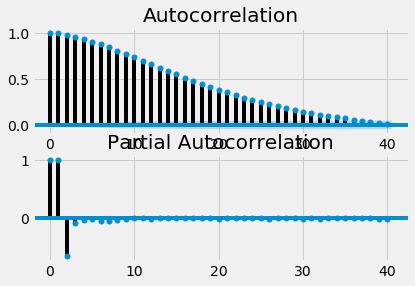

In [32]:
fig, ax = plt.subplots(2,1)
fig = sm.graphics.tsa.plot_acf(data, lags=40, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(data, lags=40, ax=ax[1])
plt.show()

#### Calculate relative quality of statistical models for a given data set using AIC estimator pick the combination which has minimum AIC value for training model.

In [ ]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:574347.5790607167
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:526944.9307503637
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:501076.88861111115
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:463652.88567043433
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:463173.9962082267


#### Dividing data into train and test data set and fit SARIMA model for prediction using walk forward validation technique

In [5]:
def train_model(data):
    predictions = pd.Series()
    model = sm.tsa.statespace.SARIMAX(data,
                                order=( 1 ,1, 1),
                                seasonal_order=(1, 0, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False).fit();
    return model;

In [20]:
train_size = int(len(data)*0.8);
train, test = data[:train_size],data[train_size:]
model= train_model(data);
print (model.summary().tables[1])

C:\Users\Darshil\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\Darshil\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7215      0.004    199.081      0.000       0.714       0.729
ma.L1         -0.1193      0.004    -33.235      0.000      -0.126      -0.112
ar.S.L12       0.6285      0.107      5.849      0.000       0.418       0.839
ma.S.L12      -0.6468      0.105     -6.147      0.000      -0.853      -0.441
sigma2        25.4700      0.014   1761.225      0.000      25.442      25.498


In [13]:
predictions = model.predict(train_size,(train_size-1)+len(test));
grount_truth = test[0]
res = pd.DataFrame();
res['Predictions'] = predictions
res['Actual'] = grount_truth
res

,Predictions,Actual
35987,129.648823,133.0
35988,128.359090,130.0
35989,127.672884,130.0
35990,129.737783,131.0
35991,131.630730,132.0
...,...,...
44840,102.717803,101.0
44841,100.604686,98.0
44842,96.173085,95.0
44843,93.002103,91.0


In [15]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
def forecast_accuracy(forecast, actual):         
    mae =  mean_absolute_error(actual, forecast)   
    mse = mean_squared_error(actual, forecast)
    rmse = sqrt(mse)         
    return({
        'mae':mae,
        'mse':mse,
        'rmse':rmse
    })

#### Calculate accuracy measurement of model using Mean Absolute Error, Mean Squared Error, Root Mean Squared Error

In [16]:
error = forecast_accuracy(predictions,grount_truth)
print (error)

{'mae': 2.5415313255287137, 'mse': 23.834645165656212, 'rmse': 4.88207385909474}


#### Predict next 1 hour of data to get intuition of meal event.

In [17]:
predictions = model.predict(train_size,(train_size-1)+12);
grount_truth = test[0].head(12);
res = pd.DataFrame();
res['Predictions'] = predictions
res['Actual'] = grount_truth
res

,Predictions,Actual
35987,129.648823,133.0
35988,128.359090,130.0
35989,127.672884,130.0
35990,129.737783,131.0
35991,131.630730,132.0
35992,132.612634,131.0
35993,130.490025,126.0
35994,123.030884,128.0
35995,128.822087,130.0
35996,131.424171,132.0


In [21]:
error = forecast_accuracy(predictions,grount_truth)
print (error)

{'mae': 1.9053260357553132, 'mse': 5.902636711962367, 'rmse': 2.4295342582401194}


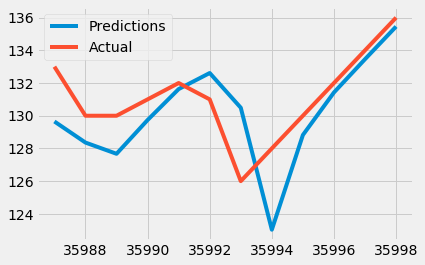

In [34]:
res.plot()